# **URBE *Perception*** 🚘 - *real-time vehicle detection for self-driving cars in Rome*

> *Refer to the notebook* [![📔](https://colab.reasearch.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1sCqnwYm9Dodk1YodD1asVpRMBBdT-8r1#scrollTo=4teaWmm61Fbl) *on **dataset** creation if you haven't already.*

## Introduction

In our case for 2D Object detection: we'll detect mostly *vehicles*, *pedestrians* and *motorbikes*. One of the most important task in computer vision and since now it reaches very high accuracy scores, we'll focus on the efficiency/latency part: how much is the inference time of the model? Is it capable of succeding in real-time tasks? 

## Imports & Downloads

In [ ]:
from src.hyperparameters import Hparams
# from sbert.baseline import SentenceBERT
# from sbert.regression_model import execute_booknlp_pipeline
# from sbert.regression_model import count_event_sentence
# from sbert.regression_model import LengthRegressionModel
from src.data_module import URBE_Dataset, URBE_DataModule
# from src.model import MatchSum
# from src.train import train_model

import dataclasses
from dataclasses import asdict
import matplotlib.pyplot as plt
import wandb
import pprint
import json
import torchvision
import torchvision.transforms as T
import pytorch_lightning as pl
import gc
from collections import Counter
import seaborn as sns
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
from math import comb
import random
import json
from datasets import load_metric
# reproducibility stuff
import numpy as np
import random
import torch
np.random.seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False
_ = pl.seed_everything(0)
# to have a better workflow using notebook https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
# these commands allow to update the .py codes imported instead of re-importing everything every time.
%load_ext autoreload
%autoreload 2
#%env WANDB_NOTEBOOK_NAME = ./notebook.ipynb
gc.collect()

In [ ]:
# login wandb to have the online logger. It is really useful since it stores all the plots and evolution of the model
# check also https://docs.wandb.ai/guides/integrations/lightning
wandb.login()

## Utilities

## Dataset

In [ ]:
# fast check to see if all the data were correctly imported
print("We should get the same number in both three cases...")
l1 = os.listdir("dataset/URBE_dataset/images/train") + os.listdir("dataset/URBE_dataset/images/test") + os.listdir("dataset/URBE_dataset/images/val")
print(len(l1))

d=json.load(open("dataset/URBE_dataset/labels/COCO/annotations.json"))
l2 = list(set([ann["image_id"] for ann in d["annotations"]]))
print(len(l2))

l3 = d["images"]
print(len(l3))

In [ ]:
hparams = asdict(Hparams())
URBE_Data = URBE_DataModule(hparams)
# to setup it takes ~6 minutes
URBE_Data.setup()
print(len(URBE_Data.data_train)) # --> 3500 images
print(len(URBE_Data.data_val)) # -->  438 images
print(len(URBE_Data.data_test)) # -->  438 images
print("TOTAL: "+str(len(URBE_Data.data_train)+len(URBE_Data.data_val)+len(URBE_Data.data_test))+" images")

### Bounding Boxes Visualization

It's needed of course for showing the results at the end of the project and during  training of the validation set, but it was essential in the *data processing* phase for understanding the qualities of the datasets' bounding boxes annotations and in general to recognize each different characteristic of the data. <br> *(I tried **Scalabel**, **FiftyOne**, but **WandB** is the best choice)* 

> Let's test the *dataloaders* and see some samples from a training batch!

In [ ]:
def draw_bbox(label):
  ris = { "predictions" : {"box_data" : [] , "class_labels" : {0 : "vehicle" , 1 : "person", 2 : "motorbike"}} }
  for ann in label: # for each bbox of the particular image
    if ann==[]: # we appended empty lists for having the same batch size for all the samples!
      break
    position = {"minX": ann[0], "maxX": ann[0] + ann[2], "minY": ann[1], "maxY": ann[1] + ann[3]}
    class_id = ann[4]
    box_caption = ris["predictions"]["class_labels"][class_id]
    x = {"position" : position, "domain" : "pixel", "class_id" : class_id, "box_caption" : box_caption}
    ris["predictions"]["box_data"].append(x)
  return ris

In [ ]:
# we take one batch from the training set
batch = next(iter(URBE_Data.train_dataloader()))

user_name = "lavallone"
project_name = "VISIOPE_project"
version_name = "prova"
run = wandb.init(entity=user_name, project=project_name, name = version_name, mode = "online")

transform = T.ToPILImage()
images_list = [transform(img) for img in batch["img"]]

my_data = []
for i,label in enumerate(batch["labels"]):
    bbox_list = draw_bbox(label) # label is a list of lists
    my_data.append([batch["id"][i], wandb.Image(images_list[i], boxes=bbox_list)])
table = wandb.Table(columns=['ID', 'Image'], data=my_data)
print("logging the table...")
wandb.log({"dataloaders testing": table})

### Statistics 📊

Before starting with the real development of the detection system, we want to plot the statistics of our data. 
> Since using the dataloaders  for all our dataset is costly and painful, it will be use the "*annotations.json*" file as a source for the dataset statistics.



In [52]:
# function for plotting data --> three group because train/val/test
def three_group_bar(columns, data, title, percentage=True): # both columns and data are lists (data is list of a single list)
  labels = columns
  
  train = data[0]
  val = data[1]
  test = data[2]
  
  color_list = []
  for _ in range(len(data)):
    color = [random.randrange(0, 255)/255, random.randrange(0, 255)/255, random.randrange(0, 255)/255, 1]
    color_list.append(color)
    
  x = np.arange(len(labels))
  width = 0.15  # the width of the bars
  fig, ax = plt.subplots(figsize=(12, 5), layout='constrained')
  rects1 = ax.bar(x - width, train, width, label='Train', color=color_list[0])
  rects2 = ax.bar(x, val, width, label='Val', color=color_list[1])
  rects3 = ax.bar(x + width, test, width, label='Test', color=color_list[2])
  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_title(title)
  ax.set_xticks(x, labels)
  ax.legend()
  if percentage:
    rects1_labels = [('%.2f' % i) + "%" for i in train]
    rects2_labels = [('%.2f' % i) + "%" for i in val]
    rects3_labels = [('%.2f' % i) + "%" for i in test]
  else:
    rects1_labels = train
    rects2_labels = val
    rects3_labels = test
  
  ax.bar_label(rects1, rects1_labels, padding=3)
  ax.bar_label(rects2, rects2_labels, padding=3)
  ax.bar_label(rects3, rects3_labels, padding=3)

In [ ]:
# setup
d = json.load(open("dataset/URBE_dataset/labels/COCO/annotations.json"))
annotations = d["annotations"]
images = d["images"]

train_image_id_list = [f.split("_")[-1][:-4] for f in os.listdir("dataset/URBE_dataset/images/train/")]
val_image_id_list = [f.split("_")[-1][:-4] for f in os.listdir("dataset/URBE_dataset/images/val/")]
test_image_id_list = [f.split("_")[-1][:-4] for f in os.listdir("dataset/URBE_dataset/images/test/")]

**Number of classes**

In [ ]:
data = []

# TRAIN
classes_list = [ann["category_id"] for ann in tqdm(annotations) if ann["image_id"] in train_image_id_list]
c = Counter(classes_list)
tot = c[0] + c[1] + c[2]
data.append([(c[0]/tot)*100, (c[1]/tot)*100, (c[2]/tot)*100])

# VAL
classes_list = [ann["category_id"] for ann in tqdm(annotations) if ann["image_id"] in val_image_id_list]
c = Counter(classes_list)
tot = c[0] + c[1] + c[2]
data.append([(c[0]/tot)*100, (c[1]/tot)*100, (c[2]/tot)*100])

# TEST
classes_list = [ann["category_id"] for ann in tqdm(annotations) if ann["image_id"] in test_image_id_list]
c = Counter(classes_list)
tot = c[0] + c[1] + c[2]
data.append([(c[0]/tot)*100, (c[1]/tot)*100, (c[2]/tot)*100])

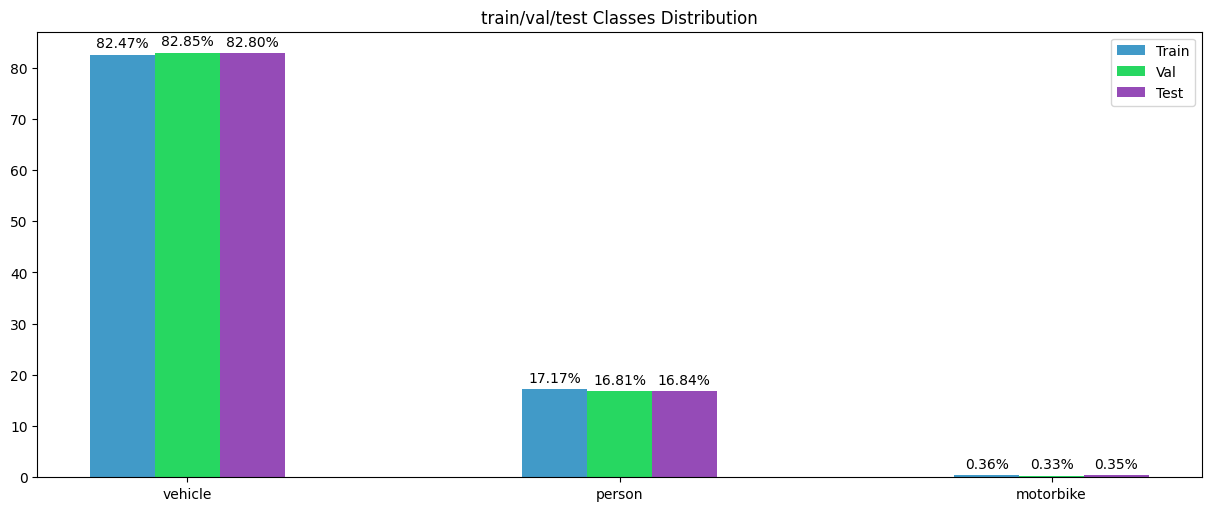

In [79]:
#data = [[82.46814899865309, 17.16686171034909, 0.364989290997814], [82.85404948638728, 16.814104764671193, 0.33184574894152646], [82.80439305749428, 16.843565364727365, 0.35204157777836304]]
columns = ["vehicle", "person", "motorbike"]
three_group_bar(columns, data, "train/val/test Classes Distribution")

**Time of the day**

In [ ]:
data = []

# TRAIN
time_list = [img["timeofday"] for img in tqdm(images) if img["id"] in train_image_id_list]
c = Counter(time_list)
tot = c["daytime"] + c["Day"] + c["night"] + c["Night"] + c["dawn/dusk"] + c["Dawn/Dusk"]
data.append([ ((c["daytime"]+c["Day"])/tot)*100, ((c["night"]+c["Night"])/tot)*100, ((c["dawn/dusk"]+c["Dawn/Dusk"])/tot)*100 ])

# VAL
time_list = [img["timeofday"] for img in tqdm(images) if img["id"] in val_image_id_list]
c = Counter(time_list)
tot = c["daytime"] + c["Day"] + c["night"] + c["Night"] + c["dawn/dusk"] + c["Dawn/Dusk"]
data.append([ ((c["daytime"]+c["Day"])/tot)*100, ((c["night"]+c["Night"])/tot)*100, ((c["dawn/dusk"]+c["Dawn/Dusk"])/tot)*100 ])

# TEST
time_list = [img["timeofday"] for img in tqdm(images) if img["id"] in test_image_id_list]
c = Counter(time_list)
tot = c["daytime"] + c["Day"] + c["night"] + c["Night"] + c["dawn/dusk"] + c["Dawn/Dusk"]
data.append([ ((c["daytime"]+c["Day"])/tot)*100, ((c["night"]+c["Night"])/tot)*100, ((c["dawn/dusk"]+c["Dawn/Dusk"])/tot)*100 ])

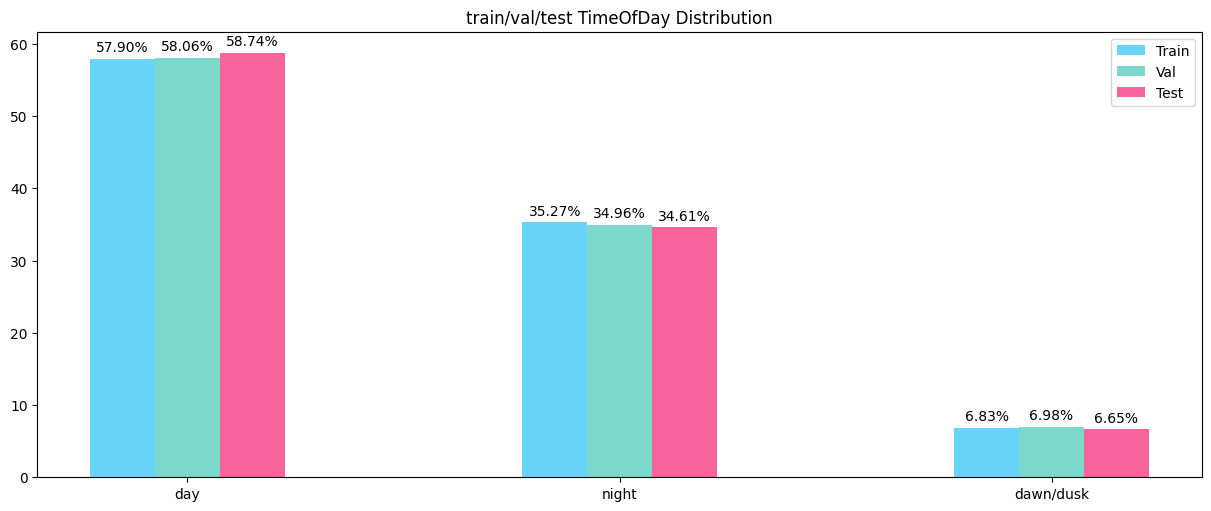

In [88]:
#data = [[57.89522657485811, 35.27379733879222, 6.830976086349678], [58.056361763879785, 34.95927347626627, 6.984364759853946], [58.73741141365162, 34.61395001864976, 6.64863856769862]]
columns = ["day", "night", "dawn/dusk"]
three_group_bar(columns, data, "train/val/test TimeOfDay Distribution")

## Model

We organized the dataset in order to be compatible with the COCO dataset. We did it initially because the **YOLOX** architecture used it. 

Now we are focusing more on the **YOLOv5**, considered the best one at the moment and with a very detailed documentation. 

We'll start with these two architectures and then in the future we'll decide the best one in terms of the  *accuracy*/*time inference* trade-off.

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd /content/yolov5
!pip install -r requirements.txt

In [ ]:
# It works extraordinarly! --> Now we dig deep to its source code
!python detect.py --source "/content/01.mp4"

# Stuff